In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics

## Preprocessing Data

### Import data

In [19]:
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_unnormalized.csv')
df.head(4)

,Unnamed: 0,index,walk_score,bike_score,transit_score,temp,month,year,outflow
0,0,38,76,82,86,73.0,JUL,2018,1
1,1,39,76,82,86,69.7,AUG,2018,0
2,2,40,76,82,86,53.4,SEP,2018,0
3,3,41,76,82,86,37.3,OCT,2018,0


In [12]:
df = df.drop(columns=['Unnamed: 0', 'index', 'year'])
y = df.iloc[:,5].to_numpy()
print(y)
df = pd.get_dummies(df,columns=['month'],drop_first=True)
df = df.drop(columns=['outflow'])
df.head()

[1 0 0 ... 6 3 0]


,walk_score,bike_score,transit_score,temp,month_AUG,month_DEC,month_FEB,month_JAN,month_JUL,month_JUN,month_MAR,month_MAY,month_NOV,month_OCT,month_SEP
0,76,82,86,73.0,0,0,0,0,1,0,0,0,0,0,0
1,76,82,86,69.7,1,0,0,0,0,0,0,0,0,0,0
2,76,82,86,53.4,0,0,0,0,0,0,0,0,0,0,1
3,76,82,86,37.3,0,0,0,0,0,0,0,0,0,1,0
4,76,82,86,34.9,0,0,0,0,0,0,0,0,1,0,0


In [20]:
## run this code cell to get ride of month and year - don't do one hot encoding
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_unnormalized.csv')
df = df.drop(columns=['Unnamed: 0', 'index', 'year', 'month'])
df.head()

,walk_score,bike_score,transit_score,temp,outflow
0,76,82,86,73.0,1
1,76,82,86,69.7,0
2,76,82,86,53.4,0
3,76,82,86,37.3,0
4,76,82,86,34.9,0


In [10]:
#try to filter out outflow that is only greater than 0
df_filter = df[df['outflow']>0]
len(df_filter)

1926

In [11]:
len(df)

1965

In [ ]:
# figure out what the bike score is from WalkScore
# could we add a second model on top --> satisfy equalized odds
# could also incorporate protected attributes in training set
# need to define equalized odds to match this problem set up
# equalized odds for regression???

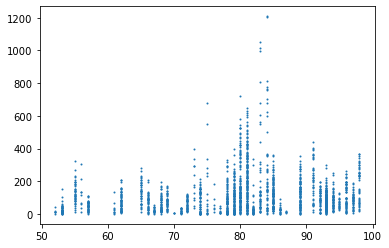

In [12]:
plt.scatter(df_filter['bike_score'], df_filter['outflow'], s=1); plt.show()

### Split data for training and test

We have a small number of locations that have bike stations. First, we need to filter out any cell that does not have any stations.

In [21]:
X = df.iloc[:, :3].to_numpy()
y = df.iloc[:,3].to_numpy() #add this line only if you did not define y in the second code cell make sure to change the values

# X = df.iloc[:, :].to_numpy() #only use this line if using the first and second code cell

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Perform Feature Scaling

## Defining Models
Code from https://towardsdatascience.com/end-to-end-case-study-bike-sharing-demand-dataset-53201926c8db

In [63]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

from sklearn.model_selection import GridSearchCV
gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

In [64]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree

RMLSE for the data: 0.967018204970957


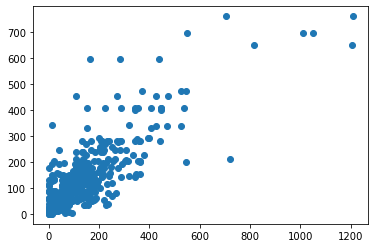

In [65]:
plt.scatter(y_test, y_pred)
plt.show()

In [66]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

from sklearn.model_selection import GridSearchCV
gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

In [67]:
RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest

RMLSE for the data: 0.9136267247059643


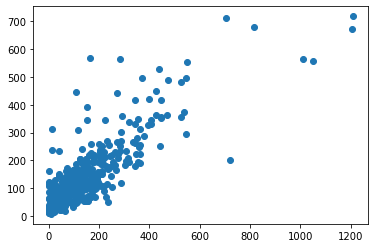

In [68]:
plt.scatter(y_test, y_pred)
plt.show()

In [69]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

In [70]:
ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost

RMLSE for the data: 0.9723812764755068


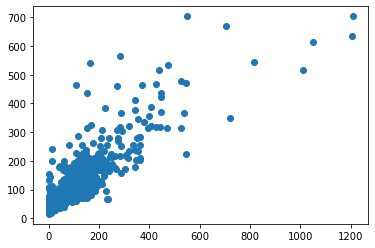

In [71]:
plt.scatter(y_test, y_pred)
plt.show()

----

In [22]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

gs_dt = GridSearchCV(dt,dt_params,cv=3)
gs_dt.fit(X_train,y_train)
a = gs_dt.best_params_

dtr=DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf= a['min_samples_leaf'])
model = dtr.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_log_error
msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For decision tree

RMLSE for the data: 0.2677168445447977


In [23]:
np.mean(y_test)

56.27694915254238

In [24]:
#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle) # For random forest

RMLSE for the data: 0.2651969864243799


In [25]:
np.mean(y_test)

56.27694915254238

In [26]:
#Adaboost Regressor
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor(base_estimator=RF,random_state=0)
ar_params = {'n_estimators':np.arange(25,200,25)}

gs_ar = GridSearchCV(ar,ar_params,cv=3)
gs_ar.fit(X_train,y_train)
c = gs_ar.best_params_

ab_rf = AdaBoostRegressor(base_estimator=RF,n_estimators=c['n_estimators'],random_state=0)
model = ab_rf.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMSLE for the data:',rmsle) # For Ada-Boost

RMSLE for the data: 0.2650229678940251


In [27]:
np.mean(y_test)

56.27694915254238

|  | RMSLE|
|:--:|:--:|
|Decision Tree| 0.967|
|Random Forest| 0.914|
|AdaBoost| 0.972|

when taking our month and year but leaving outflow == 0, the models get the following RMSLE:

|  | RMSLE|
|:--:|:--:|
|Decision Tree| 0.268|
|Random Forest| 0.265|
|AdaBoost| 0.265|

Trying a different verison of Df

In [72]:
df = pd.read_csv('../Data/PGH/DemandPrediction/learning_set_unnormalized.csv')
df = df.drop(columns=['Unnamed: 0', 'index', 'month', 'year'])

df_filter = df[df['outflow']>0]

X = df_filter.iloc[:, :4].to_numpy()
y = df_filter.iloc[:,4].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Random Forest
rf = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}

gs_rf = GridSearchCV(rf,rf_params,cv=3)
gs_rf.fit(X_train,y_train)
b = gs_rf.best_params_

RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'],random_state=0)
model = RF.fit(X_train,y_train)
y_pred = model.predict(X_test)

msle=mean_squared_log_error(y_pred,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle)

RMLSE for the data: 0.7884859620609537


import plotly.express as px

fig = px.scatter(df, y_test, y_pred, labels={'x':'ground truth', 
                          'y': 'predicted demand'},title="Random Forest")
fig.show()

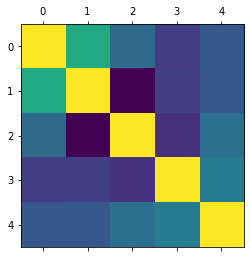

In [28]:
plt.matshow(df.corr())
plt.show()